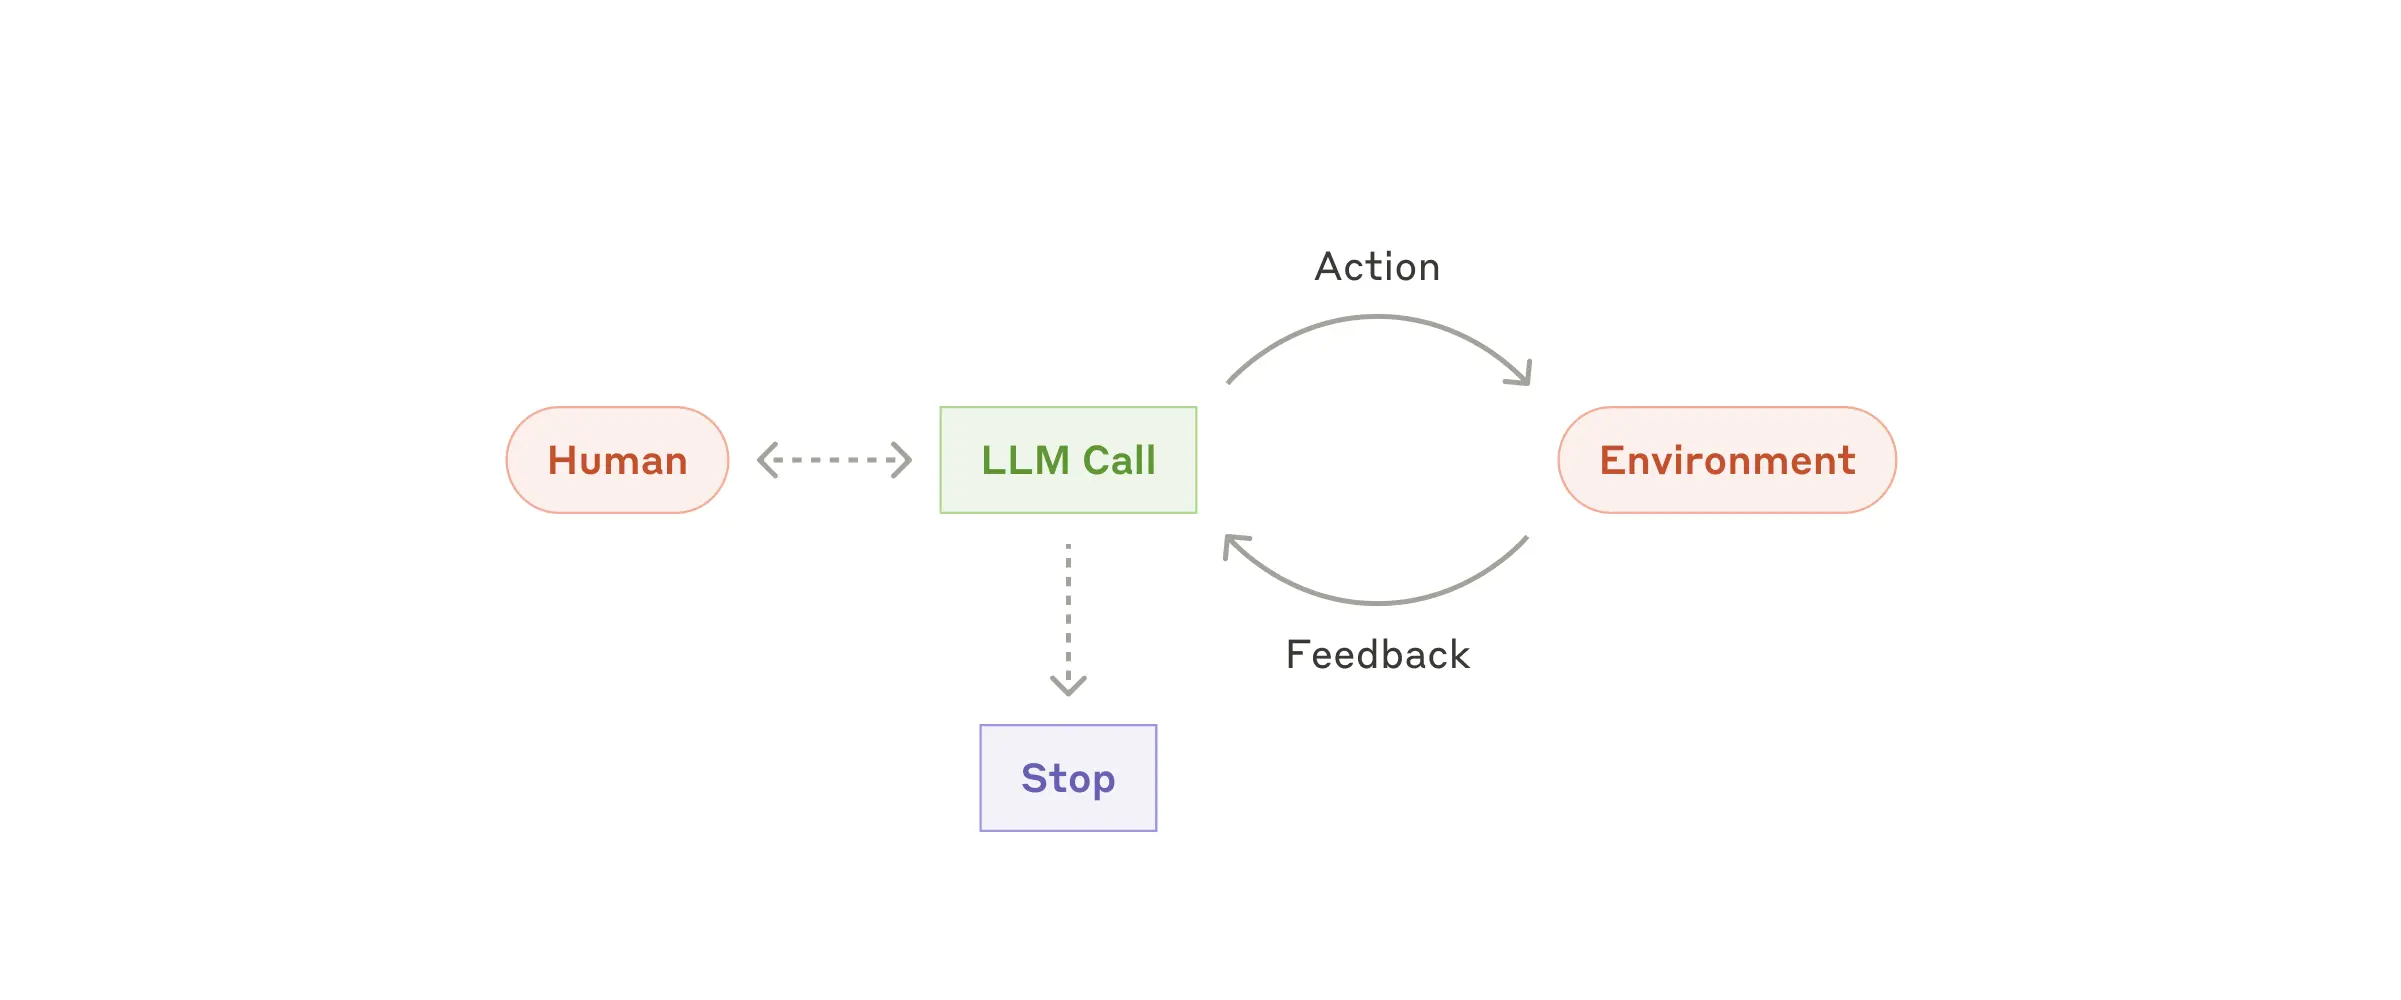

### When to use Agent?
Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

The autonomous nature of agents means higher costs, and the potential for compounding errors. We recommend extensive testing in sandboxed environments, along with the appropriate guardrails.

Examples where agents are useful:

The following examples are from our own implementations:

A coding Agent to resolve SWE-bench tasks, which involve edits to many files based on a task description;
Our “computer use” reference implementation, where Claude uses a computer to accomplish tasks.

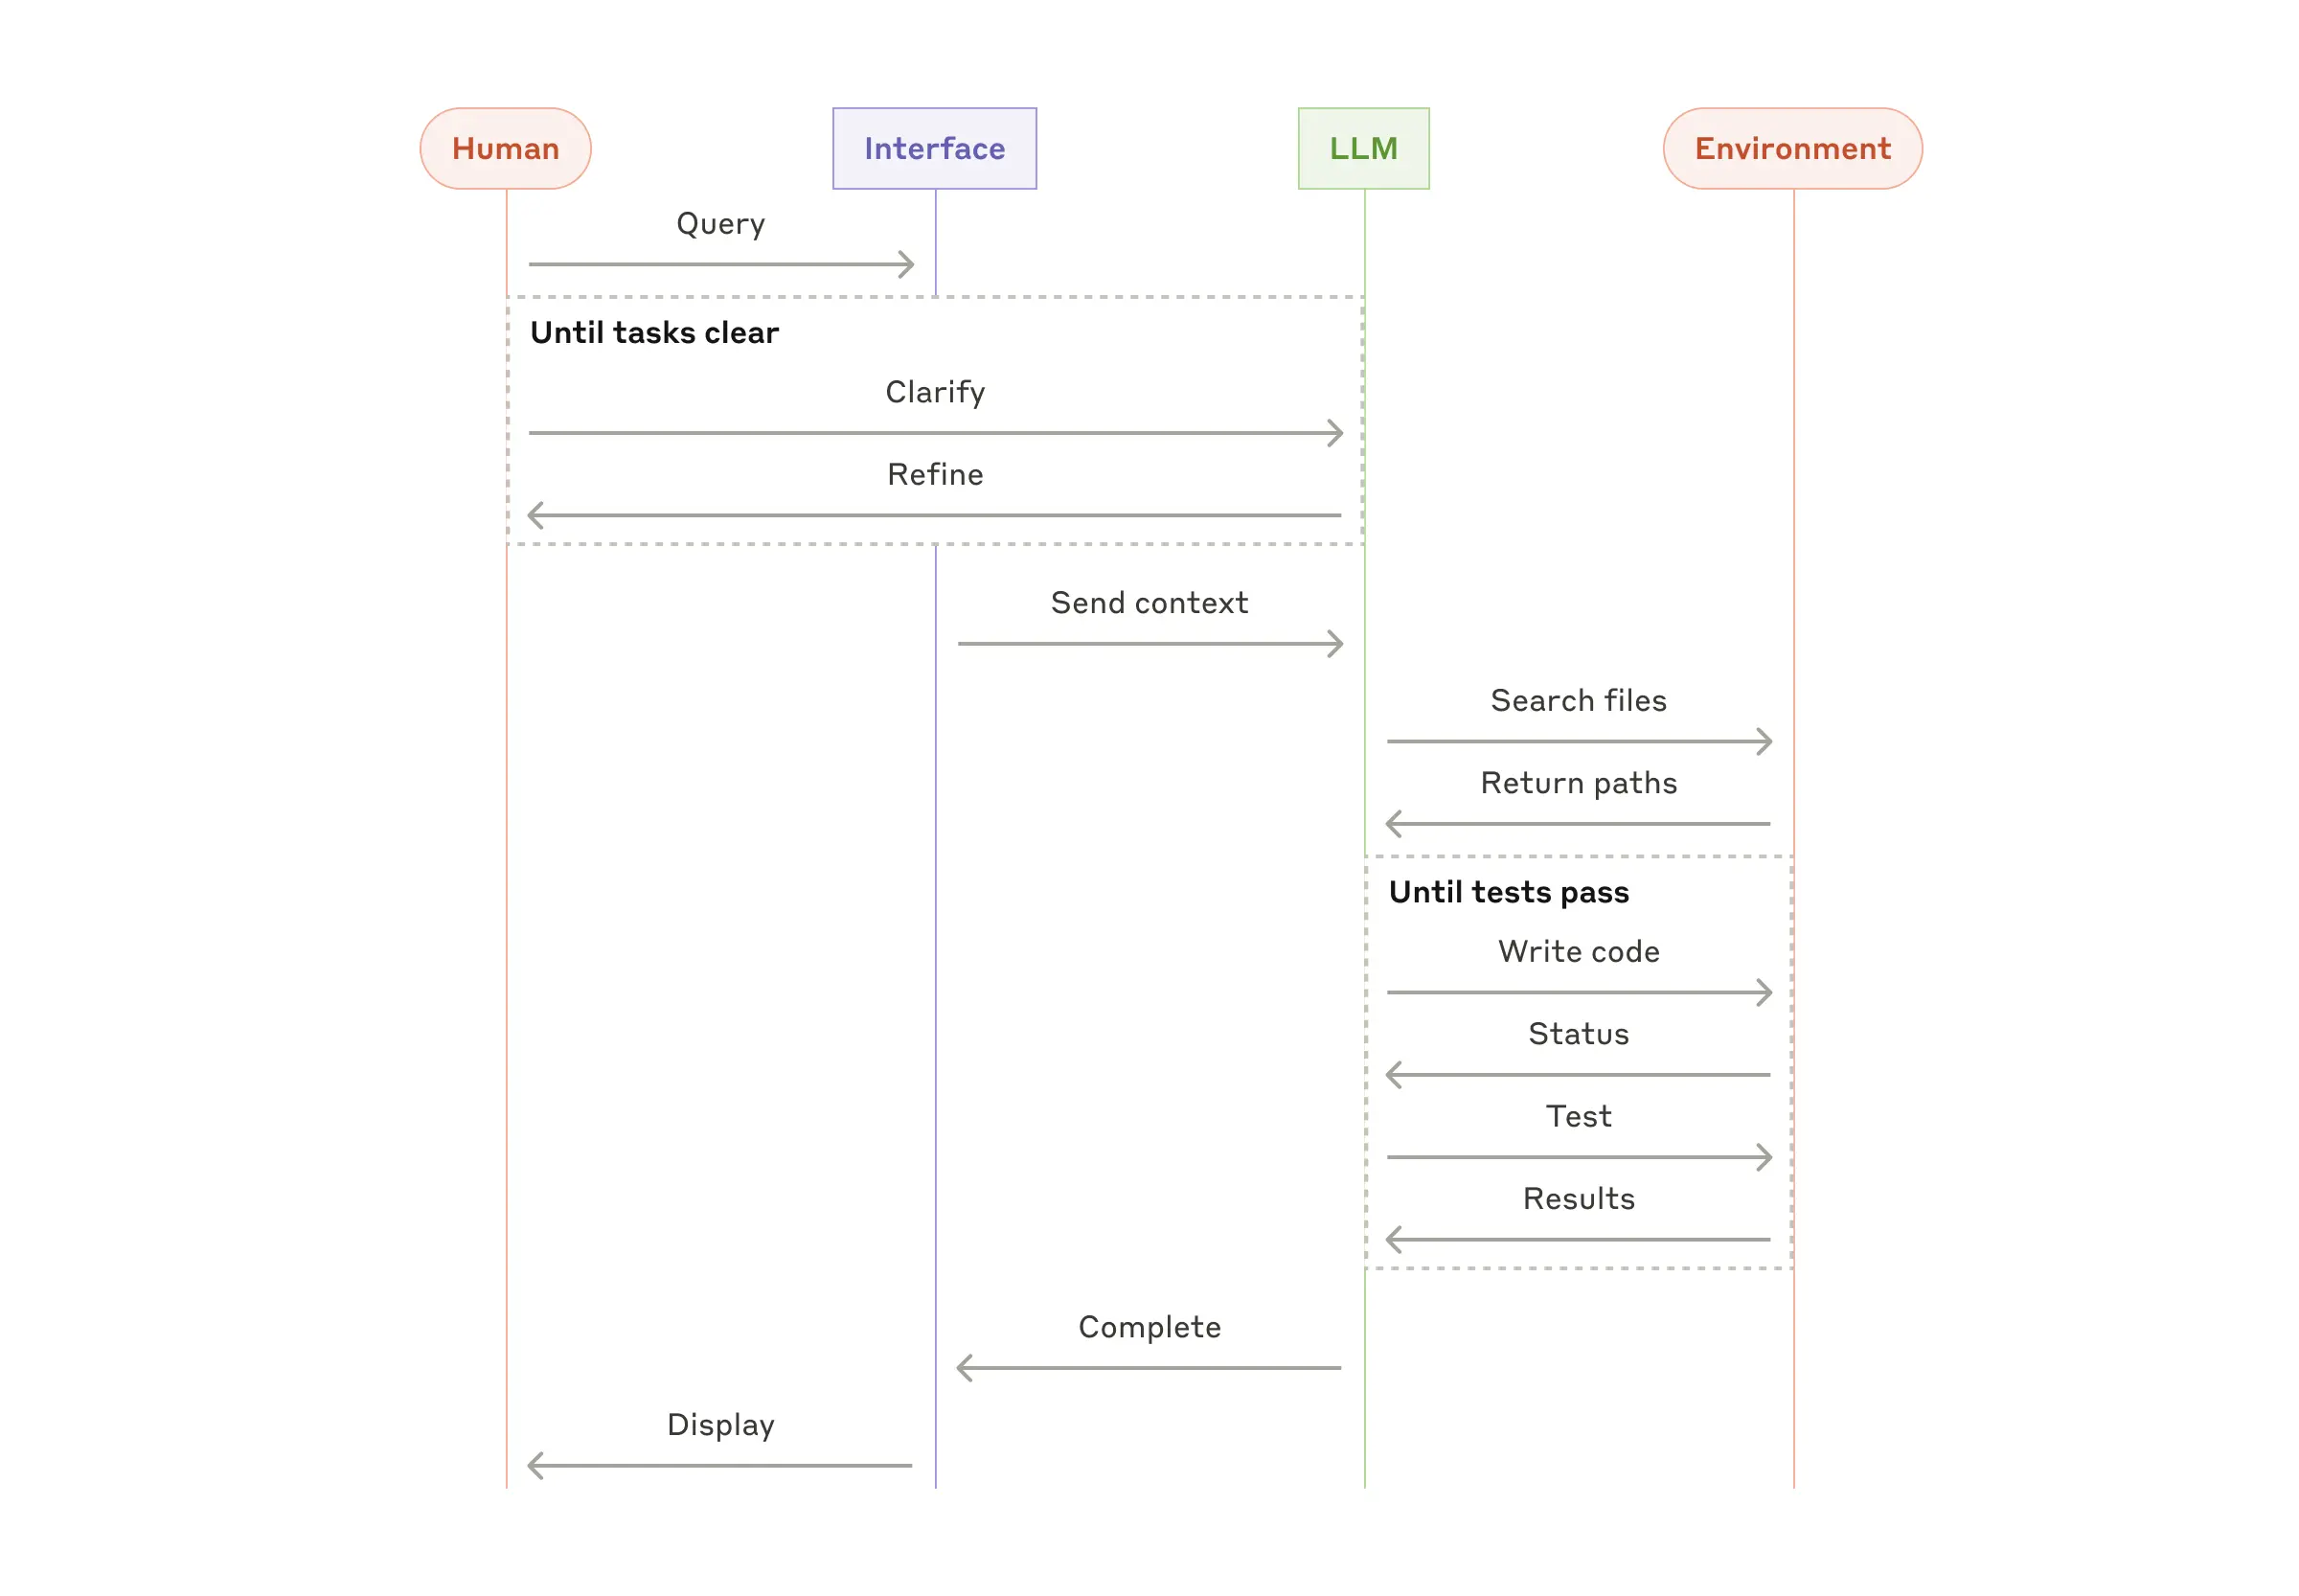

### Building Agent from scratch using langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Enter {var}: ")
    else:
        print(f"{var} already set")
        
_set_env("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

OPENAI_API_KEY already set


In [3]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b

@tool
def divide(a: int, b: int) -> int:
    """Divide two numbers"""
    return a / b

In [5]:
tools = [multiply, add, subtract, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage

def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            llm_with_tools.invoke([
                SystemMessage(
                    content="You are helpful assistant tasked with performing arithmetic on set of inputs."
                ) 
            ] + state["messages"])
        ]
    }
    
def tool_node(state: dict):
    """perform the tool call"""
    result = []
    print(state["messages"][-1].tool_calls)
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(
            ToolMessage(
                content=observation,
                tool_call_id=tool_call["id"]
            )
        )
    return {
        "messages": result
    }

from typing import Literal
from langgraph.graph import END
   
def should_continue(state: MessagesState):
    """LLM decides whether to continue or not"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return END

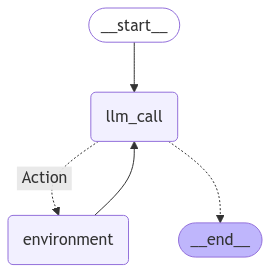

In [20]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

workflow = StateGraph(MessagesState)

workflow.add_node('llm_call', llm_call)
workflow.add_node('environment', tool_node)

workflow.add_edge(START, 'llm_call')
workflow.add_conditional_edges('llm_call', should_continue, {
    "Action": 'environment',
    END: END
})

workflow.add_edge('environment', 'llm_call')

chain = workflow.compile()

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [22]:
messages = [HumanMessage(content="I want to multiply 2 and 3 and then add 4")]
messages = chain.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_tHoJUHASBTLL7T8dslrvOTzI', 'type': 'tool_call'}, {'name': 'add', 'args': {'a': 4, 'b': 0}, 'id': 'call_9n7YTAbT5VfQMFNYf4A9Z7ft', 'type': 'tool_call'}]
6
4
[{'name': 'add', 'args': {'a': 6, 'b': 4}, 'id': 'call_0ZfV8in6DXtcEtoXbzkjigLK', 'type': 'tool_call'}]
10
================================ Human Message =================================

I want to multiply 2 and 3 and then add 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_tHoJUHASBTLL7T8dslrvOTzI)
 Call ID: call_tHoJUHASBTLL7T8dslrvOTzI
  Args:
    a: 2
    b: 3
  add (call_9n7YTAbT5VfQMFNYf4A9Z7ft)
 Call ID: call_9n7YTAbT5VfQMFNYf4A9Z7ft
  Args:
    a: 4
    b: 0
================================= Tool Message =================================

6
================================= Tool Message =================================

4
================================== Ai Message =================================

### Prebuilt Agent using langgraph

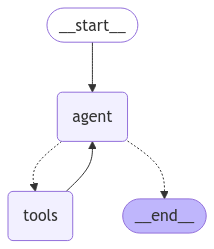

In [23]:
from langgraph.prebuilt import create_react_agent

pre_built_agent = create_react_agent(llm_with_tools, tools=tools)

display(Image(pre_built_agent.get_graph(xray=True).draw_mermaid_png()))

In [25]:
messages = [HumanMessage(content="Add 2 and 3 then multiply it by 100 and then divide by 2 and then subtract 1729")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 2 and 3 then multiply it by 100 and then divide by 2 and then subtract 1729
================================== Ai Message ==================================
Tool Calls:
  add (call_uDurcJeCcGrpXznq1qIBxWBR)
 Call ID: call_uDurcJeCcGrpXznq1qIBxWBR
  Args:
    a: 2
    b: 3
  multiply (call_uDoG4KYqsoTnCVNSvo0PBbcJ)
 Call ID: call_uDoG4KYqsoTnCVNSvo0PBbcJ
  Args:
    a: 5
    b: 100
  subtract (call_cYfboOOWZGJfdgwZoBmbJFSV)
 Call ID: call_cYfboOOWZGJfdgwZoBmbJFSV
  Args:
    a: 1729
    b: 0
================================= Tool Message =================================
Name: add

5
================================= Tool Message =================================
Name: multiply

500
================================= Tool Message =================================
Name: subtract

1729
================================== Ai Message ==================================
Tool Calls:
  divide (call_bWCiOyRO65RNA